# GPlearn 1 Minute  Period Data Alpha Factor Generating
## What is Alpha Factor?
Alpha (α) is a term used in investing to describe an investment strategy's ability to beat the market, or its "edge." Alpha is thus also often referred to as “excess return” or “abnormal rate of return,” which refers to the idea that markets are efficient, and so there is no way to systematically earn returns that exceed the broad market as a whole. Alpha is often used in conjunction with beta (the Greek letter β), which measures the broad market's overall volatility or risk, known as systematic market risk.  

Alpha is used in finance as a measure of performance, indicating when a strategy, trader, or portfolio manager has managed to beat the market return over some period. Alpha, often considered the active return on an investment, gauges the performance of an investment against a market index or benchmark that is considered to represent the market’s movement as a whole.  

The excess return of an investment relative to the return of a benchmark index is the investment’s alpha. Alpha may be positive or negative and is the result of active investing. Beta, on the other hand, can be earned through passive index investing.(Retrived from https://www.investopedia.com/terms/a/alpha.asp)  

Alpha Factor is a mathmatical expression that tries to identify the strategy that can provide information on the future trend of the market. Alpha factor examples can be found on https://www.spglobal.com/marketintelligence/en/solutions/alpha-factor-library.  
## What is GPlearn and symbolic transformer?
gplearn implements Genetic Programming in Python, with a scikit-learn inspired and compatible API.

While Genetic Programming (GP) can be used to perform a very wide variety of tasks, gplearn is purposefully constrained to solving symbolic regression problems. This is motivated by the scikit-learn ethos, of having powerful estimators that are straight-forward to implement.Genetic programming is capable of taking a series of totally random programs, untrained and unaware of any given target function you might have had in mind, and making them breed, mutate and evolve their way towards the truth.

Think of genetic programming as a stochastic optimization process. Every time an initial population is conceived, and with every selection and evolution step in the process, random individuals from the current generation are selected to undergo random changes in order to enter the next. You can control this randomness by using the random_state parameter of the estimator.  

A symbolic transformer is a supervised transformer that begins by building a population of naive random formulas to represent a relationship. The formulas are represented as tree-like structures with mathematical functions being recursively applied to variables and constants. Each successive generation of programs is then evolved from the one that came before it by selecting the fittest individuals from the population to undergo genetic operations such as crossover, mutation or reproduction. The final population is searched for the fittest individuals with the least correlation to one another.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import graphviz

from scipy.stats import rankdata
import scipy.stats as stats

from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
import baostock as bs
from ta.volume import VolumeWeightedAveragePrice
import statsmodels.api as sm
from scipy.stats.mstats import zscore
import talib

from scipy.stats import spearmanr
import datetime
from numba import jit
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import math
import cloudpickle
import matplotlib.pyplot as plt
%matplotlib inline

# Import and Prepare Data

In [2]:
data_df = pd.read_csv('dataset/PTA1分钟历史数据.csv')
data_df = data_df.rename(columns = {"Unnamed: 0": "date"})

data_df.head(3)

,date,open,close,high,low,volume,money
0,2014-03-21 09:01:00,6278.0,6272.0,6280.0,6262.0,8086.0,253796760.0
1,2014-03-21 09:02:00,6274.0,6266.0,6278.0,6266.0,2978.0,93449640.0
2,2014-03-21 09:03:00,6266.0,6266.0,6270.0,6262.0,6364.0,199612500.0


In [3]:
fields = ['open','close','high','low','volume','money']
length = []

df = data_df.copy()
df.high = df.high.values.astype('float64')
df.low = df.low.values.astype('float64')
df.close = df.close.values.astype('float64')
df.open = df.open.values.astype('float64')
df.volume = df.volume.values.astype('float64')
df.amount = df.money.values.astype('float64')

df.tail(3), df.head(3), df.isnull().any()

(                       date    open   close    high     low  volume  \
 633657  2021-09-24 22:58:00  5206.0  5210.0  5210.0  5206.0  8295.0   
 633658  2021-09-24 22:59:00  5210.0  5194.0  5212.0  5194.0  8423.0   
 633659  2021-09-24 23:00:00  5194.0  5202.0  5204.0  5192.0  6532.0   
 
               money  
 633657  214425750.0  
 633658  217734550.0  
 633659  168852200.0  ,
                   date    open   close    high     low  volume        money
 0  2014-03-21 09:01:00  6278.0  6272.0  6280.0  6262.0  8086.0  253796760.0
 1  2014-03-21 09:02:00  6274.0  6266.0  6278.0  6266.0  2978.0   93449640.0
 2  2014-03-21 09:03:00  6266.0  6266.0  6270.0  6262.0  6364.0  199612500.0,
 date      False
 open      False
 close     False
 high      False
 low       False
 volume    False
 money     False
 dtype: bool)

## Calculate The 1 Minute Rate of Return for Backtest

In [4]:
df['1_min_return'] = df.open.pct_change(1).shift(-1)
df = df.dropna()

df.tail(3)

,date,open,close,high,low,volume,money,1_min_return
633656,2021-09-24 22:57:00,5202.0,5206.0,5208.0,5200.0,5257.0,135893450.0,0.000769
633657,2021-09-24 22:58:00,5206.0,5210.0,5210.0,5206.0,8295.0,214425750.0,0.000768
633658,2021-09-24 22:59:00,5210.0,5194.0,5212.0,5194.0,8423.0,217734550.0,-0.003071


## Split Training and Testing Datase# 分割训练和测试数据

In [5]:
train_data=df[(df.date<'2020-08-01')]
train_data=train_data.reset_index(drop=True)

train_data.head(3), train_data.tail(3), train_data.shape

(                  date    open   close    high     low  volume        money  \
 0  2014-03-21 09:01:00  6278.0  6272.0  6280.0  6262.0  8086.0  253796760.0   
 1  2014-03-21 09:02:00  6274.0  6266.0  6278.0  6266.0  2978.0   93449640.0   
 2  2014-03-21 09:03:00  6266.0  6266.0  6270.0  6262.0  6364.0  199612500.0   
 
    1_min_return  
 0     -0.000637  
 1     -0.001275  
 2      0.000000  ,
                        date    open   close    high     low  volume  \
 537552  2020-07-31 22:58:00  3574.0  3578.0  3578.0  3574.0  1410.0   
 537553  2020-07-31 22:59:00  3576.0  3578.0  3580.0  3576.0  3611.0   
 537554  2020-07-31 23:00:00  3578.0  3576.0  3580.0  3576.0  3609.0   
 
              money  1_min_return  
 537552  25281300.0      0.000560  
 537553  64745230.0      0.000559  
 537554  64709370.0      0.000559  ,
 (537555, 8))

In [6]:
test_data=df[(df.date>='2020-08-01')]
test_data=test_data.reset_index(drop=True)

test_data.head(3), test_data.shape

(                  date    open   close    high     low  volume        money  \
 0  2020-08-03 09:01:00  3580.0  3582.0  3588.0  3578.0  7838.0  140535340.0   
 1  2020-08-03 09:02:00  3582.0  3578.0  3584.0  3576.0  6935.0  124344550.0   
 2  2020-08-03 09:03:00  3578.0  3576.0  3580.0  3572.0  4178.0   74869760.0   
 
    1_min_return  
 0      0.000559  
 1     -0.001117  
 2     -0.000559  ,
 (96104, 8))

In [7]:
X_train = train_data.drop(columns=['date','1_min_return']).to_numpy()
y_train = train_data['1_min_return'].values

X_train, X_train.shape, y_train, y_train.shape

(array([[6.2780000e+03, 6.2720000e+03, 6.2800000e+03, 6.2620000e+03,
         8.0860000e+03, 2.5379676e+08],
        [6.2740000e+03, 6.2660000e+03, 6.2780000e+03, 6.2660000e+03,
         2.9780000e+03, 9.3449640e+07],
        [6.2660000e+03, 6.2660000e+03, 6.2700000e+03, 6.2620000e+03,
         6.3640000e+03, 1.9961250e+08],
        ...,
        [3.5740000e+03, 3.5780000e+03, 3.5780000e+03, 3.5740000e+03,
         1.4100000e+03, 2.5281300e+07],
        [3.5760000e+03, 3.5780000e+03, 3.5800000e+03, 3.5760000e+03,
         3.6110000e+03, 6.4745230e+07],
        [3.5780000e+03, 3.5760000e+03, 3.5800000e+03, 3.5760000e+03,
         3.6090000e+03, 6.4709370e+07]]),
 (537555, 6),
 array([-0.00063715, -0.0012751 ,  0.        , ...,  0.0005596 ,
         0.00055928,  0.00055897]),
 (537555,))

In [8]:
X_test = test_data.drop(columns=['date', '1_min_return']).to_numpy()
y_test = test_data['1_min_return'].values

X_test, X_test.shape, y_test, y_test.shape

(array([[3.5800000e+03, 3.5820000e+03, 3.5880000e+03, 3.5780000e+03,
         7.8380000e+03, 1.4053534e+08],
        [3.5820000e+03, 3.5780000e+03, 3.5840000e+03, 3.5760000e+03,
         6.9350000e+03, 1.2434455e+08],
        [3.5780000e+03, 3.5760000e+03, 3.5800000e+03, 3.5720000e+03,
         4.1780000e+03, 7.4869760e+07],
        ...,
        [5.2020000e+03, 5.2060000e+03, 5.2080000e+03, 5.2000000e+03,
         5.2570000e+03, 1.3589345e+08],
        [5.2060000e+03, 5.2100000e+03, 5.2100000e+03, 5.2060000e+03,
         8.2950000e+03, 2.1442575e+08],
        [5.2100000e+03, 5.1940000e+03, 5.2120000e+03, 5.1940000e+03,
         8.4230000e+03, 2.1773455e+08]]),
 (96104, 6),
 array([ 0.00055866, -0.00111669, -0.00055897, ...,  0.00076894,
         0.00076834, -0.00307102]),
 (96104,))

# Add More Functions and a Customized Backtest Fitness Function for GPlearn


In [9]:
init_function = ['add', 'sub', 'mul', 'div','sqrt', 'log','inv','sin','max','min']
def _ts_beta(x1, x2, n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                u'''need：(list1,list2,number)  return：number
                前 n 期样本 A 对 B 做回归所得回归系数'''
                list1 = x1.flatten().tolist()
                list2 = x2.flatten().tolist()
                n = int(n[0])
                list1 = np.array(list1[-n-1:]).reshape(-1, 1)
                list2 = np.array(list2[-n-1:]).reshape(-1, 1)
                linreg = LinearRegression()
                model = linreg.fit(list1, list2)
                res = linreg.coef_.tolist()[0]
                res = np.array(res+[0]*(len(x1)-len(linreg.coef_))).flatten()
                return res
            else:
                return np.zeros(x1.shape[0])
        except:
            return np.zeros(x1.shape[0])
        
def _ts_resid(x1, x2, n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                u'''need：(list1,list2,number)  return：number
                前 n 期样本 A 对 B 做回归所得的残差'''
                list1 = x1.flatten().tolist()
                list2 = x2.flatten().tolist()
                n = int(n[0])
                list1 = np.array(list1[-n-1:]).reshape(-1, 1)
                list2 = np.array(list2[-n-1:]).reshape(-1, 1)
                linreg = LinearRegression()
                model = linreg.fit(list1, list2)
                res = list(linreg.intercept_)
                res = np.array(res+[0]*(len(x1)-len([linreg.intercept_]))).flatten()
                return res
            else:
                return np.zeros(x1.shape[0])
        except:
            return np.zeros(x1.shape[0])
        
def _corr(data1,data2,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window  = n[0]
                x1 = pd.Series(data1.flatten())
                x2 = pd.Series(data2.flatten())
                df = pd.concat([x1,x2],axis=1)
                temp = pd.Series()
                for i in range(len(df)):
                    if i<=window-2:
                        temp[str(i)] = np.nan
                    else:
                        df2 = df.iloc[i-window+1:i,:]
                        temp[str(i)] = df2.corr('spearman').iloc[1,0]
                return np.nan_to_num(temp)
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0])
        
def SEQUENCE(n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                a = n[0]
                res = np.array(list(range(1, a+1)))
                res = res.tolist()+[0]*(len(n)-len(res))
                return np.array(res).flatten()
            else:
                return np.zeros(n.shape[0])
        except:
            return np.zeros(n.shape[0])

def _ts_prod(x, n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                x = pd.Series(x.flatten())
                n = n[0]
                res = x.prod(min_count=n)
                res = np.array([res]+[0]*(len(x)-1))
                return res
            else:
                return np.zeros(x.shape[0]) 
        except:
            return np.zeros(data1.shape[0]) 
        
def _ts_cov(x,y,window):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n1[1] == n[2]:
                x = pd.Series(x.flatten())
                y = pd.Series(y.flatten())
                res = x.rolling(window).cov(y).fillna(0).values
                return res
            else:
                return np.zeros(x.shape[0]) 
        except:
            return np.zeros(x.shape[0])

def _ts_lowday(x1, n1):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n1[0] == n1[1] and n1[1] == n1[2]:
                '''need：(list,number)  return：number
                计算 A 前 n 期时间序列中最小值距离当前时点的间隔'''
                n = int(n1[0])
                x = x1.flatten().tolist()    
                lowday = n-x[-n:].index(min(list(x)[-n:]))-1
                return np.array([lowday]+[0]*(len(x)-1))
            else:
                return np.zeros(x1.shape[0]) 
        except:
            return np.zeros(x1.shape[0]) 
        
def _ts_highday(x1, n1):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n1[0] == n1[1] and n1[1] == n1[2]:
                u'''need：(list,number)  return：number
                计算 A 前 n 期时间序列中最大值距离当前时点的间隔'''
                n = int(n1[0])
                x = x1.flatten().tolist()
                highday = n-x[-n:].index(max(list(x)[-n:]))-1
                return np.array([highday]+[0]*(len(x)-1))
            else:
                return np.zeros(x1.shape[0]) 
        except:
            return np.zeros(x1.shape[0]) 
        
def _ts_adv(x,d):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if d[0] == d[1] and d[1] == d[2]:
                d = int(d[0])
                reslist(map(lambda t: np.mean(x.flatten()[t:t+20]),range(len(x.flatten())-d+1)))
                res = res[numpy.isneginf(res)] = 0
                return np.array(res)
            else:
                return np.zeros(x.shape[0])
        except:
            return np.zeros(x.shape[0])
            
def _ts_wma(x1,d):
        with np.errstate(divide='ignore', invalid='ignore'):
            try:
                if d[0] == d[1] and d[1] == d[2]:
                    d = int(d[0])
                    x1 = pd.Series(x1.flatten())
                    weights = np.arange(1,d+1)
                    wma = x1.rolling(d).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
                    wma = wma.fillna(0).values
                    return wma
                else:
                    return np.zeros(x1.shape[0])
            except:
                return np.zeros(x1.shape[0])

def _ts_mean(X, d):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if d[0] == d[1] and d[1] == d[2]:
                X = pd.Series(X.flatten())
                res = X.rolling(window=d[0]).mean()
                res = res.fillna(0).values
                return res
            else:
                return np.zeros(X.shape[0])
        except:
            return np.zeros(X.shape[0])

def _decay_linear(data1,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                n = int(n[0])
                w = np.arange(1,n+1)
                w = w[::-1]
                w = np.array(w)/np.sum(w)
                res = list(map(lambda t: np.sum(np.multiply(np.array(data1.flatten()[t:t+n]),w)),range(len(data1.flatten())-n+1)))
                return np.array(res).flatten()
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0])

def _abs(x1):
    return abs(x1.flatten())

def _ts_abs(data1, n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                window = int(n[0])
                x1 = data1.flatten()
                temp1 = x1[-window:]
                temp1 = np.abs(temp1)
                temp2 = x1[:-window]
                result = np.append(temp2,temp1)
                return result
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0]) 

def _ts_scale(data1, n):
        with np.errstate(divide='ignore', invalid='ignore'):
            try:
                if n[0] == n[1] and n[1] == n[2]:
                    return (int(n[0])*x1 / np.nansum(np.abs(data1.flatten())))
                else:
                    return np.zeros(data1.shape[0])
            except:
                return np.zeros(data1.shape[0])
            
def _signedpower(data1, n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                return np.sign(data1.flatten()) * np.power(np.abs(data1.flatten()), int(n[0]))
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0]) 

def _ts_delta(data1,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                a1 = data1-pd.Series(data1.flatten()).shift(periods=int(n[0]))
                a1 = a1.fillna(0).values
                return a1
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0]) 

def _ts_delay(data1,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] == n[2]:
                a1 = pd.Series(data1.flatten())
                a1 = a1.shift(periods=int(n[0]))
                a1 = a1.fillna(0).values
                return a1
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0]) 

def _ts_corr(data1,data2,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                x1 = pd.Series(data1.flatten())
                x2 = pd.Series(data2.flatten())
                df = pd.concat([x1,x2],axis=1)
                temp = pd.Series()
                for i in range(len(df)):
                    if i<=window-2:
                        temp[str(i)] = np.nan
                    else:
                        df2 = df.iloc[i-window+1:i,:]
                        temp[str(i)] = df2.corr('spearman').iloc[1,0]
                return np.nan_to_num(temp)
            else:
                return np.zeros(data1.shape[0])
        except:
            return np.zeros(data1.shape[0]) 

def _ts_sum(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = np.array(pd.Series(data.flatten()).rolling(window).sum().tolist())
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])
        
def _ts_sma(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):   
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])

def _ts_stddev(data,n):   
    with np.errstate(divide='ignore', invalid='ignore'): 
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])

def _ts_rank(x1,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                n = int(n[0])
                x2 = pd.Series(x1.flatten()[-n:])
                res = x2.rank(pct=True).values
                res = res.tolist()+[0]*(x1.shape[0] - res.shape[0])
                return np.array(res)
            else:
                return np.zeros(x1.shape[0]) 
        except:
            return np.zeros(x1.shape[0]) 
        
def _ts_argmin(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = pd.Series(data.flatten()).rolling(window).apply(np.argmin) + 1 
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])  
        except:
            return np.zeros(data.shape[0])  

def _ts_argmax(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = pd.Series(data.flatten()).rolling(window).apply(np.argmax) + 1 
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0]) 
        
def _ts_min(data,n):
    import numpy as np
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = np.array(pd.Series(data.flatten()).rolling(window).min().tolist())
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])

def _ts_max(data,n):
    with np.errstate(divide='ignore', invalid='ignore'):
        try:
            if n[0] == n[1] and n[1] ==n[2]:
                window = int(n[0])
                value = np.array(pd.Series(data.flatten()).rolling(window).max().tolist())
                value = np.nan_to_num(value)
                return value
            else:
                return np.zeros(data.shape[0])
        except:
            return np.zeros(data.shape[0])
@jit
def _beta(x1, x2):
    list1 = x1.flatten().tolist()
    list2 = x2.flatten().tolist()
    list1 = np.array(list1).reshape(-1, 1)
    list2 = np.array(list2).reshape(-1, 1)
    linreg = LinearRegression()
    model = linreg.fit(list1, list2)
    res = linreg.coef_.tolist()[0]
    res = np.array(res+[0]*(len(x1)-len(linreg.coef_))).flatten()
    return res

def _resid(x1, x2):
    list1 = x1.flatten().tolist()
    list2 = x2.flatten().tolist()
    list1 = np.array(list1).reshape(-1, 1)
    list2 = np.array(list2).reshape(-1, 1)
    linreg = LinearRegression()
    model = linreg.fit(list1, list2)
    res = linreg.coef_.tolist()[0]
    res = np.array(res+[0]*(len(x1)-len(linreg.intercept_))).flatten()
    return res 

def _beta(x1, x2):
    list1 = x1.flatten().tolist()
    list2 = x2.flatten().tolist()
    list1 = np.array(list1).reshape(-1, 1)
    list2 = np.array(list2).reshape(-1, 1)
    linreg = LinearRegression()
    model = linreg.fit(list1, list2)
    res = linreg.coef_.tolist()[0]
    res = np.array(res+[0]*(len(x1)-len(linreg.coef_))).flatten()
    return res

def _abs(x1):
    return abs(x1.flatten())

def _rank(x1):
    x1 = pd.Series(x1.flatten())
    return x1.rank(pct=True).values
        
def _cube(data):
    return np.square(data.flatten())*data.flatten()

def _square(data):
    return np.square(data.flatten())

def _ts_argmaxmin(data,n):
    try:
        return _ts_argmax(data,n) - _ts_argmin(data,n)
    except:
        return np.zeros(data.shape[0])

def _my_metric_backtest(y, y_pred, w):
    pred = pd.Series(y_pred.flatten()).fillna(0)
    y = pd.Series(y.flatten()).fillna(0)
    short_profit = 0
    long_profit = 0
    held_long = 0
    held_short = 0
    profit = []
    profit_temp = 0
    
    for i in range(len(pred)):
        current_pred = pred.iloc[i]
        current_return = y.iloc[i]
        #open long
        if current_pred>=0.75 and held_long==0 and held_short==0:
            held_long = 1
            held_short = 0
            long_profit += current_return
                    
        #hold long
        elif current_pred>=0.75 and held_long==1 and held_short==0:
            held_long = 1
            held_short = 0
            long_profit += current_return
            
        #open long and close short
        elif current_pred>=0.75 and held_long==0 and held_short==1:
            #close short and record profit
            held_long = 1
            held_short = 0
            short_profit += (-current_return)
            profit.append(short_profit)
            #open long
            long_profit += current_return
                    
        #open short
        elif current_pred<=-0.75and held_long==0 and held_short==0:
            held_long = 0
            held_short = 1
            short_profit += (-current_return)
            
        #keep short
        elif current_pred<=-0.75 and held_long==0 and held_short==1:
            held_long = 0
            held_short = 1
            short_profit += (-current_return)
  
        #close long and open short
        elif current_pred <=-0.75 and held_long==1 and held_short==0:
            #close long
            held_long = 0
            held_short = 1
            long_profit += current_return
            profit.append(long_profit)
            #open short
            short_profit += (-current_return)
                    
        #closeout long 
        elif current_pred<0.75 and current_pred>-0.75 and held_long==1 and held_short==0:
            held_long = 0
            held_short = 0
            long_profit += current_return
            profit.append(long_profit)      
            
        #closeout short    
        elif current_pred<0.75 and current_pred>-0.75 and held_long==0 and held_short==1:
            held_long = 0
            held_short = 0
            short_profit += (-current_return)
            profit.append(short_profit)
    try:        
        total_return = profit[-1]
    except:
        total_return = 0
        
    result = total_return
    
    del pred
    del y
    del short_profit
    del long_profit
    del held_long
    del held_short
    del profit
    
    return result

## Activate The Customized Fuctions

In [10]:
ts_beta = make_function(function = _ts_beta, name='ts_beta', arity=3, wrap=False)
beta = make_function(function = _beta, name='beta', arity=2, wrap=False)
ts_resid = make_function(function = _ts_resid, name='ts_resid', arity=3, wrap=False)
resid = make_function(function = _resid, name='resid', arity=2, wrap=False)
corr = make_function(function = _corr, name='corr', arity=3, wrap=False) 
SEQUENCE = make_function(function=SEQUENCE, name='SEQUENCE', arity=1, wrap=False) 
ts_cov = make_function(function=_ts_cov, name='ts_cov', arity=3, wrap=False) 
ts_lowday = make_function(function=_ts_lowday, name='ts_lowday', arity=2, wrap=False) 
ts_highday = make_function(function=_ts_highday, name='ts_highday', arity=2, wrap=False) 
ts_adv = make_function(function=_ts_adv, name='ts_adv', arity=2, wrap=False)  
ts_wma = make_function(function=_ts_wma, name='ts_wma', arity=2, wrap=False)       
ts_mean = make_function(function=_ts_mean, name='ts_mean', arity=2, wrap=False) 
decay_linear = make_function(function=_decay_linear, name='decay_linear', arity=2, wrap=False) 
_abs = make_function(function=_abs, name='_abs', arity=1, wrap=False) 
ts_abs = make_function(function=_ts_abs, name='ts_abs', arity=2, wrap=False) 
rank = make_function(function=_rank, name='rank', arity=1, wrap=False) 
ts_scale = make_function(function=_ts_scale, name='ts_scale', arity=2, wrap=False) 
ts_delta = make_function(function=_ts_delta, name='ts_delta', arity=2, wrap=False) 
ts_delay = make_function(function=_ts_delay, name='ts_delay', arity=2, wrap=False)  
ts_sma = make_function(function=_ts_sma, name='ts_sma', arity=2, wrap=False)     
ts_std = make_function(function=_ts_stddev, name='ts_std', arity=2, wrap=False)     
ts_rank = make_function(function=_ts_rank, name='ts_rank', arity=2, wrap=False)
ts_stddev = make_function(function=_ts_stddev, name='ts_stddev', arity=2, wrap=False)
ts_sum = make_function(function=_ts_sum, name='ts_sum', arity=2, wrap=False)
ts_corr = make_function(function=_ts_corr, name='ts_corr', arity=3, wrap=False)
ts_min = make_function(function=_ts_min, name='ts_min', arity=2, wrap=False)
cube = make_function(function=_cube, name='cube', arity=1, wrap=False)
square = make_function(function=_square, name='square', arity=1, wrap=False)
ts_argmaxmin = make_function(function=_ts_argmaxmin, name='ts_argmaxmin', arity=2, wrap=False)
ts_argmax = make_function(function=_ts_argmax, name='ts_argmax', arity=2)
ts_argmin = make_function(function=_ts_argmin, name='ts_argmin', arity=2, wrap=False)
ts_min = make_function(function=_ts_min, name='ts_min', arity=2, wrap=False)
ts_max = make_function(function=_ts_max, name='ts_max', arity=2, wrap=False)
#decay_linear,ts_corr(replaced by corr),
user_function = [SEQUENCE, ts_cov, ts_lowday, ts_highday, ts_adv, ts_wma, ts_mean, _abs, rank, ts_scale, ts_delta, ts_delay, 
                 ts_sma, ts_std, ts_rank, ts_sum, corr, ts_min, cube, square, ts_argmaxmin, ts_argmax, ts_argmin, ts_min, ts_max, ts_beta,
                beta, ts_resid, resid]

## Activate The Customized Fitness Function

In [11]:
my_metric = make_fitness(function=_my_metric_backtest, greater_is_better=True)

# Fit The Model

In [12]:
function_set = init_function + user_function
population_size = 5000
generations = 100
random_state= 5
est_gp = SymbolicTransformer(
                            feature_names=fields, 
                            function_set=function_set,
                            generations=generations,
                            metric=my_metric,
                            population_size=population_size,
                            tournament_size=30, 
                            random_state=random_state,
                            verbose=2, hall_of_fame=100,
                            parsimony_coefficient=0.0001,
                            p_crossover = 0.4,
                            p_subtree_mutation = 0.01,
                            p_hoist_mutation = 0,
                            p_point_mutation = 0.01,
                            p_point_replace = 0.4,
                            n_jobs = 8)
     
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 69.8min remaining: 209.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 75.7min finished


   0    31.46       -0.0188075       27          12.3871              N/A   7496.11m


SymbolicTransformer(feature_names=['open', 'close', 'high', 'low', 'volume',
                                   'money'],
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'sin', 'max', 'min',
                                  <gplearn.functions._Functi...
                                  <gplearn.functions._Function object at 0x000001340DECF700>, ...],
                    generations=100,
                    metric=<gplearn.fitness._Fitness object at 0x000001340D141DF0>,
                    n_jobs=8, p_crossover=0.4, p_hoist_mutation=0,
                    p_point_replace=0.4, parsimony_coefficient=0.0001,
                    population_size=5000, random_state=5, tournament_size=30,
                    verbose=2)

## Resulting Alpha Factors

In [13]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict

,fitness,expression,depth,length
alpha_10,0.156346,sin(cube(close)),2,3
alpha_9,0.325947,"mul(low, sin(money))",2,4
alpha_7,0.383441,"sub(add(ts_sum(_abs(min(close, money)), SEQUEN...",5,57
alpha_6,0.388041,"sub(inv(ts_std(volume, 0.670)), div(min(open, ...",3,11
alpha_8,0.388041,"sub(ts_lowday(min(close, high), ts_sum(low, hi...",3,11
alpha_5,0.404158,"min(cube(sin(close)), corr(ts_scale(open, volu...",3,14
alpha_4,0.834534,"sin(mul(open, high))",2,4
alpha_3,6.596452,log(square(sin(low))),3,4
alpha_2,6.71933,inv(sin(high)),2,3
alpha_1,12.384383,"log(sub(add(rank(inv(low)), ts_rank(div(close,...",5,27


# Save The Model

In [15]:
filename = 'gplearn_PTA_1min_factors.pkl'
with open(filename, 'wb') as f:
     cloudpickle.dump(est_gp, f)

# Read The Model File

In [16]:
filename = 'gplearn_PTA_1min_factors.pkl'
with open(filename, 'rb') as f:
    est_gp = cloudpickle.load(f)

In [17]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict

,fitness,expression,depth,length
alpha_10,0.156346,sin(cube(close)),2,3
alpha_9,0.325947,"mul(low, sin(money))",2,4
alpha_7,0.383441,"sub(add(ts_sum(_abs(min(close, money)), SEQUEN...",5,57
alpha_6,0.388041,"sub(inv(ts_std(volume, 0.670)), div(min(open, ...",3,11
alpha_8,0.388041,"sub(ts_lowday(min(close, high), ts_sum(low, hi...",3,11
alpha_5,0.404158,"min(cube(sin(close)), corr(ts_scale(open, volu...",3,14
alpha_4,0.834534,"sin(mul(open, high))",2,4
alpha_3,6.596452,log(square(sin(low))),3,4
alpha_2,6.71933,inv(sin(high)),2,3
alpha_1,12.384383,"log(sub(add(rank(inv(low)), ts_rank(div(close,...",5,27


# Visualize The Alpha Factor Expressions

log(sub(add(rank(inv(low)), ts_rank(div(close, low), SEQUENCE(money))), resid(ts_scale(SEQUENCE(low), ts_argmaxmin(low, -0.620)), mul(ts_cov(open, high, high), min(open, -0.012)))))
fitness: 12.38438262210482, depth: 5, length: 27


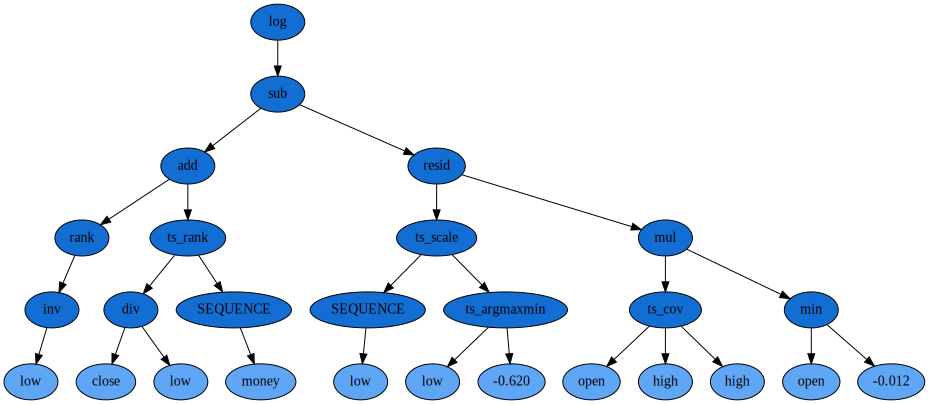

In [18]:
def alpha_factor_graph(num):
    # 打印指定num的表达式图

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

graph1 = alpha_factor_graph(1)
graph1

In [19]:
factor = best_programs[0]
print(factor)
print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

log(sub(add(rank(inv(low)), ts_rank(div(close, low), SEQUENCE(money))), resid(ts_scale(SEQUENCE(low), ts_argmaxmin(low, -0.620)), mul(ts_cov(open, high, high), min(open, -0.012)))))
fitness: 12.38438262210482, depth: 5, length: 27


# Alpha Factor Analysis

## 因子回测函数 

In [20]:
@jit
def _factor_backtest(factor_perd, market_price):
    pred = pd.Series(factor_perd.flatten()).fillna(0)
    evaluation = []
    slippage = 4
    shares = 25
    comission = 0.00025
     
    backtest_data = market_price
    trades = pred

    short_open = 0
    long_open = 0
    held_long = 0
    held_short = 0
    profit = []
    profit_temp = 0
    initial_assets = shares*max(backtest_data.open.values)
    initial_cash = shares*max(backtest_data.open.values)
    net_worth = [initial_cash]
    
    for i in range(len(trades)):
        current_pred = trades.iloc[i]
        current_close = backtest_data.iloc[i].open.astype('float')
        #open long
        if current_pred>=0.75 and held_long==0 and held_short==0:
            held_long = 1
            held_short = 0
            long_open = current_close+slippage
            short_open = 0
            #print('open long')
                    
        #hold long
        elif current_pred>=0.75 and held_long==1 and held_short==0:
            #print('hold long')
            pass
                
            #open long and close short
        elif current_pred>=0.75 and held_long==0 and held_short==1:
            held_long = 1
            #close short and calculate profit
            held_short = 0
            profit_temp = (short_open-(current_close+slippage))*shares*(1-comission)
            initial_cash += profit_temp
            profit.append(profit_temp)
            net_worth.append(initial_cash)
            #open long
            short_open = 0
            long_open = current_close+slippage
            #print('open long and close short')
                    
        #open short
        elif current_pred<=-0.75and held_long==0 and held_short==0:
            held_long = 0
            held_short = 1
            long_open = long_open
            short_open = current_close+slippage
            profit = profit
            #print('open short')
            
        #keep short
        elif current_pred<=-0.75 and held_long==0 and held_short==1:
            #print('keep short')
            pass
                
        #close long and open short
        elif current_pred <=-0.75 and held_long==1 and held_short==0:
            #close long
            held_long = 0
            held_short = 1
            profit_temp = ((current_close-slippage)-long_open)*shares*(1-comission)
            initial_cash += profit_temp
            profit.append(profit_temp)
            net_worth.append(initial_cash)
            #open short
            long_open = 0
            short_open = current_close-slippage
            profit = profit
            #print('close long and open short')
                    
        #closeout long
        elif current_pred<0.75 and current_pred>-0.75 and held_long==1 and held_short==0:
            held_long = 0
            held_short = 0
            profit_temp = ((current_close-slippage)-long_open)*shares*(1-comission)
            initial_cash += profit_temp
            profit.append(profit_temp)
            net_worth.append(initial_cash)
            short_open = 0
            long_open = 0
            #print('closeout long')        
            
        #closeout short    
        elif current_pred<0.75 and current_pred>-0.75 and held_long==0 and held_short==1:
            held_long = 0
            held_short = 0
            profit_temp = (short_open-(current_close+slippage))*shares*(1-comission)
            initial_cash += profit_temp
            profit.append(profit_temp)
            net_worth.append(initial_cash)
            short_open = 0
            long_open = 0
            #print('closeout short')
            
    total_return = (initial_cash-initial_assets)/initial_assets
    print('总收益率', total_return)
    shaprpe_df = pd.Series(profit)
    sharpe_temp = (shaprpe_df - shaprpe_df.shift(1))/shaprpe_df.shift(1)
    sharpe = sharpe_temp.mean()/sharpe_temp.std()*np.sqrt(len(profit))
          
    a = np.maximum.accumulate(net_worth)
    l = np.argmax((np.maximum.accumulate(net_worth) - net_worth)/np.maximum.accumulate(net_worth))
    k = np.argmax(net_worth[:l])
    max_draw = (net_worth[k] - net_worth[l])/(net_worth[l]) 
    print('最大回撤', max_draw)        
        
    win_count = 0
    loss_count = 0
    initial_profit = 0
    for i in range(len(net_worth)):
        current_profit = net_worth[i]
        if i==0:
            if current_profit > initial_assets:
                win_count += 1
            else:
                loss_count += 1
        else:
            last_profit = net_worth[i-1]
            if current_profit > last_profit:
                win_count += 1
            else:
                loss_count += 1
    win_rate = win_count/len(net_worth)
    print('胜率', win_rate)
    
    total_gain = 0
    total_loss = 0
    for i in range(len(profit)):
        if profit[i] >0:
            total_gain += profit[i]
        else:
            total_loss += profit[i]
    gain_loss_ratio = (total_gain/win_count)/(abs(total_loss)/loss_count)
    print('盈亏比', gain_loss_ratio)
    
    result = total_return*np.nan_to_num(sharpe,nan=1)*win_rate*gain_loss_ratio*(1-max_draw)
    
    x = np.array(net_worth).reshape(len(net_worth),)
    y = np.arange(len(net_worth))
    
    plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
    plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
    fig = plt.figure(figsize=(16,9))
    plt.plot(y, x)
    plt.title('因子资金曲线',fontsize=20)
    plt.xlabel('交易次数',fontsize=20)
    plt.ylabel('账户净值',fontsize=20)
    plt.show()

    return result

## Prepare Alpha Factor Backtest Results (In-Sample)

In [21]:
factors_pred = est_gp.transform(X_train)
factors_pred.shape, X_train.shape

((537555, 10), (537555, 6))

In [22]:
pred_data = pd.DataFrame(factors_pred).T.T
pred_data, pred_data.iloc[:,[0]]

(               0          1         2         3         4         5  \
 0       0.100368  22.882979 -0.653085  0.900637  0.000000 -0.999682   
 1      -1.264464   1.123289 -0.008746  0.989437  0.000000 -0.999363   
 2      -0.146115  -1.723635 -0.653085 -0.999216  0.000000 -0.999362   
 3       0.114995  -1.274463 -2.220488  0.825151 -0.483079 -0.998407   
 4      -0.148354   1.123289 -0.036217  0.989437 -0.483079 -0.999363   
 ...          ...        ...       ...       ...       ...       ...   
 537550  0.667190   1.311040 -0.181889  0.967394  0.000000 -0.998881   
 537551  0.512656   1.311040 -0.198645 -0.997367  0.000000 -1.000000   
 537552  0.633991   3.695278 -0.198645  0.706805  0.000000 -0.998882   
 537553  0.512296  -1.012161 -0.541641  0.920581  0.000000 -0.998883   
 537554  0.112663  -1.012161 -0.541641 -0.757335  0.000000 -0.999441   
 
                    6              7            8         9  
 0      -1.163984e+12 -515272.962015 -3847.113515 -0.999276  
 1      -1

## Alpha Factor Backtest Results (In-Sample)

总收益率 18.505672747580395
最大回撤 0.002646899619426275
胜率 0.712678746716897
盈亏比 7.897330418750164


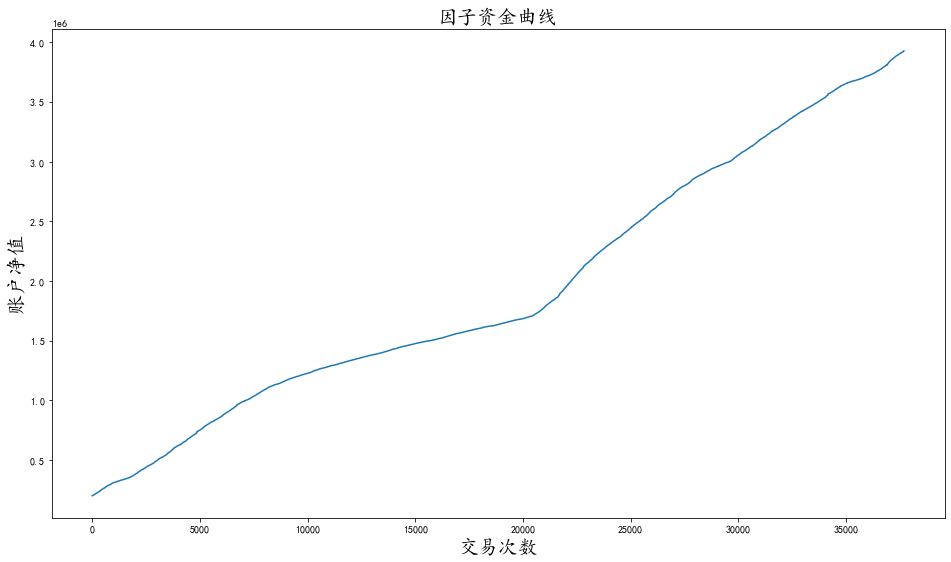

103.87904216943294

In [23]:
#Total Rate of Return: 总收益率
#Max drawdown: 最大回撤
#Wining Rate: 胜率
#Win-loss ratio:盈亏比
#Graph Title: Factor Backtest Account Networth cruve
#Graph X Axis: Number of Trades
#Graph y Axis: Account Networth
_factor_backtest(pred_data.iloc[:,[0]].values, train_data)

## Prepare Alpha Factor Backtest Results (Out-of-Sample)

In [24]:
factors_pred_1 = est_gp.transform(X_test)
factors_pred_1.shape, X_test.shape

((96104, 10), (96104, 6))

In [25]:
pred_data_1 = pd.DataFrame(factors_pred_1).T.T
pred_data_1, pred_data_1.iloc[:,[0]]

(              0          1         2         3         4         5  \
 0      0.524718   3.370902 -2.614112 -0.638455  0.000000 -0.997770   
 1      0.367585   1.890978 -0.541641  0.863733  0.000000 -0.999442   
 2      0.527684  -1.012161  0.000000 -0.757335  0.000000 -0.999441   
 3      0.527684   3.695278  0.000000  0.234697  0.000000 -0.999441   
 4      0.527684   1.311040  0.000000  0.091613  0.000000 -0.999441   
 ...         ...        ...       ...       ...       ...       ...   
 96099 -1.594632   1.151090 -0.118088 -0.888143 -0.837670 -0.999230   
 96100  0.055283  -2.176269 -0.118088 -0.976671 -0.234197 -0.997309   
 96101 -0.085450  -1.450599 -0.967729  0.995723 -0.051406 -0.998848   
 96102 -0.303794   1.057549 -1.978670 -0.578769  0.000000 -0.999232   
 96103 -1.602842 -10.242552 -0.416836  0.510597 -0.535125 -0.999616   
 
                   6             7            8         9  
 0     -6.247722e+11 -21968.402408   891.993268  0.935941  
 1     -4.891073e+11    -7

## Alpha Factor Backtest Results (Out-of-Sample)

总收益率 5.333650336045313
最大回撤 0.009763898723050963
胜率 0.7675511751326762
盈亏比 6.328575792104121


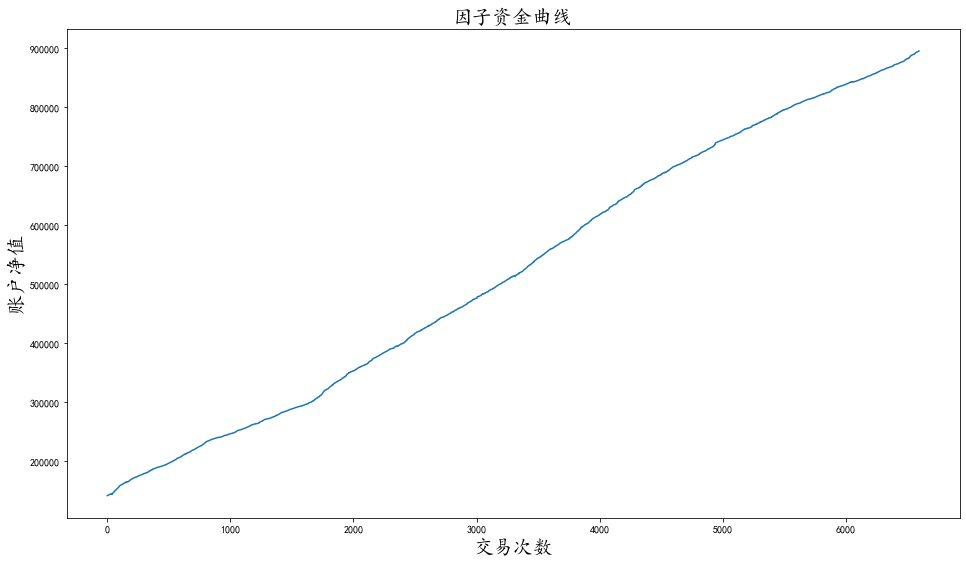

25.65527196285825

In [26]:
#Total Rate of Return: 总收益率
#Max drawdown: 最大回撤
#Wining Rate: 胜率
#Win-loss ratio:盈亏比
#Graph Title: Factor Backtest Account Networth cruve
#Graph X Axis: Number of Trades
#Graph y Axis: Account Networth
_factor_backtest(pred_data_1.iloc[:,[0]].values, test_data)